In [185]:
import festim as F
import fenics as f
import h_transport_materials as htm
import numpy as np

In [186]:
# Nickel material properties and dimensions
nickel_diffusivity = htm.diffusivities.filter(material=htm.NICKEL).mean()
nickel_solubility = htm.solubilities.filter(material=htm.NICKEL).mean()
nickel_permeability = htm.permeabilities.filter(material=htm.NICKEL).mean()
nickel_length = 2e-3 # in m

nickel = F.Material(
    id=1,
    D_0 = nickel_diffusivity.pre_exp.magnitude,
    E_D = nickel_diffusivity.act_energy.magnitude,
    S_0 = nickel_solubility.pre_exp.magnitude,
    E_S = nickel_solubility.act_energy.magnitude,
)


In [187]:
# FLiBe material properties and dimensions
flibe_diffusivity = htm.diffusivities.filter(material=htm.FLIBE).mean()
flibe_solubility = htm.solubilities.filter(material=htm.FLIBE).mean()
flibe_permeability = htm.permeabilities.filter(material=htm.FLIBE).mean()
flibe_length = 20e-3

flibe = F.Material(
    id=1,
    D_0=flibe_diffusivity.pre_exp.magnitude,
    E_D=flibe_diffusivity.act_energy.magnitude,
    S_0 = flibe_solubility.pre_exp.magnitude,
    E_S = flibe_solubility.act_energy.magnitude,
)


In [188]:
# Building and running the nickel model
nickel_model = F.Simulation()

# 2mm thick mesh
nickel_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, nickel_length, num=1001)
)
nickel_model.materials = nickel
nickel_model.T = F.Temperature(value=973)

P_up = 101325  # Pa

nickel_model.boundary_conditions = [
    F.SievertsBC(surfaces=1, S_0=nickel.S_0, E_S=nickel.E_S, pressure=P_up),
    F.DirichletBC(surfaces=2, value=0, field=0)
]

nickel_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=1 * 3600 # s
    )

nickel_model.dt = F.Stepsize(initial_value=10, stepsize_change_ratio=1.1)

derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])

folder = "1D_model"
nickel_model.exports = [
        F.XDMFExport(field="solute", filename=f"{folder}/nickel_concentration.xdmf", checkpoint=False),
        derived_quantities,
    ]

In [189]:
# Running the model

nickel_model.initialise()
nickel_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        3.6e+03 s    Ellapsed time so far: 0.4 s


In [190]:
# Defining the downstream flux for salt and metal

def downstream_flux_salt(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up * permeability / L * (2*summation + 1)

def downstream_flux_metal(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): material permeability
        L (float): material thickness
        D (float): diffusivity of H in the material

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up**0.5 * permeability / L * (2*summation + 1)

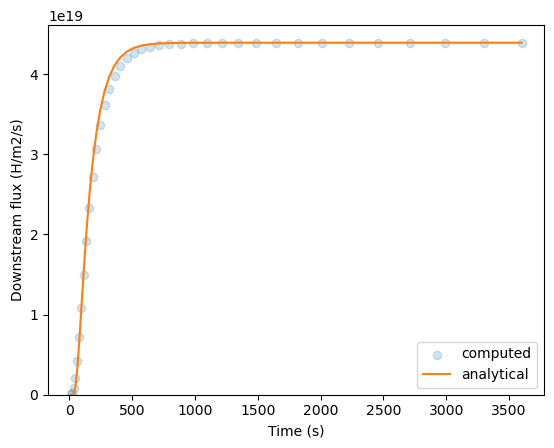

In [191]:
# Plotting the model and the analytical solution
times = derived_quantities.t
computed_flux = derived_quantities.filter(surfaces=2).data

import matplotlib.pyplot as plt
T = 973.15 * htm.ureg.K
plt.scatter(times, np.abs(computed_flux), alpha=0.2, label="computed")
plt.plot(times, downstream_flux_metal(times * htm.ureg.sec, P_up * htm.ureg.Pa,
                                permeability=nickel_diffusivity.value(T)*nickel_solubility.value(T), 
                                L=nickel_length*htm.ureg.m, D=nickel_diffusivity.value(T)), color="tab:orange", label="analytical")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.show()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        5.4e+04 s    Ellapsed time so far: 0.7 s


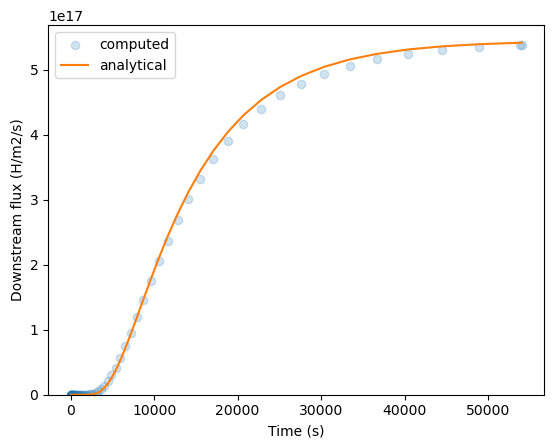

In [192]:
# Building, running, and plotting the flibe model
# Building and running the nickel model
flibe_model = F.Simulation()

# 20mm thick mesh
flibe_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, flibe_length, num=1001)
)
flibe_model.materials = flibe
flibe_model.T = F.Temperature(value=973)

P_up = 101325  # Pa

flibe_model.boundary_conditions = [
    F.HenrysBC(surfaces=1, H_0=flibe.S_0, E_H=flibe.E_S, pressure=P_up),
    F.DirichletBC(surfaces=2, value=0, field=0)
]

flibe_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=15 * 3600 # s
    )

flibe_model.dt = F.Stepsize(initial_value=10, stepsize_change_ratio=1.1)
flibe_derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])
flibe_model.exports = [
        F.XDMFExport(field="solute", filename=f"{folder}/flibe_concentration.xdmf", checkpoint=False),
        flibe_derived_quantities,
    ]
flibe_model.initialise()
flibe_model.run()

times = flibe_derived_quantities.t
flibe_computed_flux = flibe_derived_quantities.filter(surfaces=2).data

T = 973.15 * htm.ureg.K
plt.scatter(times, np.abs(flibe_computed_flux), alpha=0.2, label="computed")
plt.plot(times, downstream_flux_salt(times * htm.ureg.sec, P_up * htm.ureg.Pa,
                                permeability=flibe_diffusivity.value(T)*flibe_solubility.value(T), 
                                L=flibe_length*htm.ureg.m, D=flibe_diffusivity.value(T)), color="tab:orange", label="analytical")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.show()

In [193]:
# Changing material IDs and assigning borders

nickel.borders = [0, nickel_length]

flibe.borders = [nickel_length, nickel_length + flibe_length]
flibe.id = 2
flibe.solubility_law = "henry"

model_barrier = F.Simulation()
model_barrier.materials = [nickel, flibe]

vertices_bottom = np.linspace(0, nickel_length, num = 500)
vertices_top = np.linspace(nickel_length, nickel_length + flibe_length, num = 500)
vertices = np.concatenate([vertices_bottom, vertices_top])

model_barrier.mesh = F.MeshFromVertices(vertices)

model_barrier.T = F.Temperature(973)

bottom_bc = F.SievertsBC(
    surfaces=1,
    S_0=nickel.S_0,
    E_S=nickel.E_S,
    pressure = P_up
)

# Assuming zero concentration on the top surface
top_bc = F.DirichletBC(
    field="solute",
    surfaces=2,
    value=0
)

model_barrier.boundary_conditions = [bottom_bc, top_bc]

derived_quantities_with_barrier = F.DerivedQuantities([F.HydrogenFlux(surface=2)])
txt_export = F.TXTExport(
    field='solute',
    filename=f"{folder}/barrier_concentration.txt", 
    times = [0.1*3600,0.2*3600,1*3600, 5*3600, 12*3600])
model_barrier.exports = [
        F.XDMFExport(field="solute", filename=f"{folder}/barrier_concentration.xdmf", checkpoint=False),
        derived_quantities_with_barrier,
        txt_export
    ]

model_barrier.settings = F.Settings(
    absolute_tolerance=1e8,
    relative_tolerance=1e-10,
    final_time=20*3600, # 12 hours
    chemical_pot=True,
)

model_barrier.dt = F.Stepsize(
    initial_value=10,
    stepsize_change_ratio=1.1,
)

In [194]:
# Running the model
model_barrier.initialise()
model_barrier.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        7.2e+04 s    Ellapsed time so far: 3.1 s


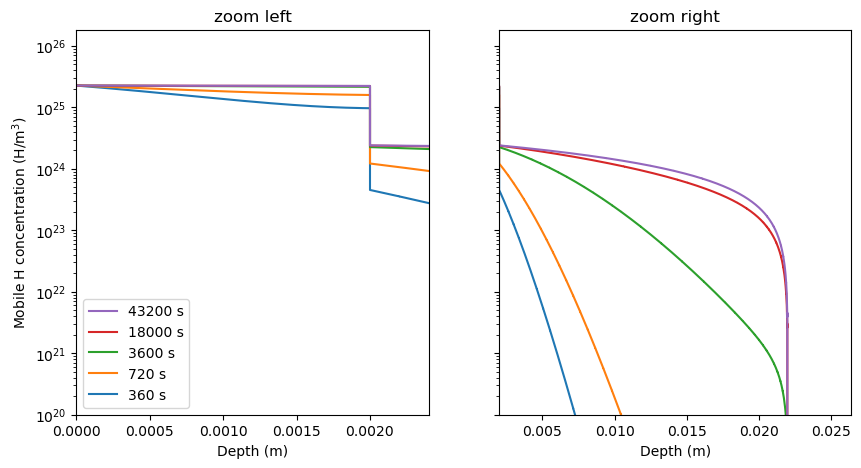

In [195]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
data = np.genfromtxt(folder + f"/barrier_concentration.txt", skip_header=1, delimiter=",")
data = data[data[:, 0].argsort()]  # make sure data is sorted

xlim_left = (0, nickel_length * 1.2)
xlim_right = (nickel_length, (nickel_length + flibe_length) * 1.2)

for ax, xlim in zip(
    axs,
    [xlim_left, xlim_right],
):
    plt.sca(ax)
    for i, time in enumerate(txt_export.times):
        plt.plot(data[:, 0], data[:, i + 1], label=f"{time:.0f} s")

    plt.xlabel("Depth (m)")
    plt.xlim(*xlim)

axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e20)
axs[0].set_ylabel("Mobile H concentration (H/m$^3$)")
axs[0].set_title("zoom left")
axs[1].set_title("zoom right")
axs[0].legend(reverse=True)
plt.show()

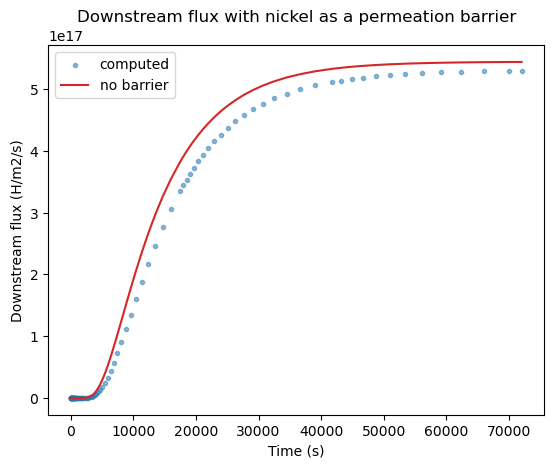

In [196]:
# Plotting the model and the analytical solution to the flibe
times = derived_quantities_with_barrier.t
barrier_computed_flux = derived_quantities_with_barrier.filter(surfaces=2).data

T = 973.15 * htm.ureg.K
plt.figure()
plt.scatter(times, np.abs(barrier_computed_flux), alpha=0.5, label="computed", marker = ".")

plt.plot(times, downstream_flux_salt(times * htm.ureg.sec, P_up * htm.ureg.Pa,
                                permeability=flibe_diffusivity.value(T)*flibe_solubility.value(T), 
                                L=flibe_length*htm.ureg.m, D=flibe_diffusivity.value(T)), color="tab:red", label="no barrier")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.title("Downstream flux with nickel as a permeation barrier")
plt.show()

In [197]:
print("diff",flibe_diffusivity.value(T))
print("sol",flibe_solubility.value(T))
print("perm",flibe_diffusivity.value(T)*flibe_solubility.value(T))

diff 4.405873723009074e-09 meter ** 2 / second
sol 2.4392423122641113e+19 particle / meter ** 3 / pascal
perm 107469936076.56342 particle / meter / pascal / second
